Fundamentos de ciência de dados - Luiz Davi e Thiago Cavalcanti

In [33]:
from nba_api_jogadores_utils import obter_logs_dos_jogos_por_jogador
from constantes_jogadores import DICIONARIO_JOGADORES, TEMPORADA_ATUAL
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Regressão Linear: variáveis dependentes e independentes 

## RF3 – Possível uso  de variáveis independentes:  tempo que o jogador passou em quadra, arremessos tentados e turnovers. Variáveis dependentes, pontos, assistências e rebotes. Divida os dados de teste e treinamento.

Coletando os dados

In [3]:
lista_de_dataframes = []
for nome, id in DICIONARIO_JOGADORES.items():
    dados = obter_logs_dos_jogos_por_jogador(id, TEMPORADA_ATUAL)
    dados = dados[['GAME_DATE', 'MIN', 'FGA', 'TOV', 'PTS', 'AST', 'REB']]
    dados['PLAYER'] = nome
    lista_de_dataframes.append(dados)

In [4]:
dataframe_nba = pd.concat(lista_de_dataframes)
dataframe_nba.columns = ['Data', 'Minutos', 'Arremessos', 'Turnovers', 'Pontos', 'Assistências', 'Rebotes', 'Jogador']

dataframe_nba.head()

,Data,Minutos,Arremessos,Turnovers,Pontos,Assistências,Rebotes,Jogador
0,"FEB 01, 2025",37,17,4,28,17,13,Nikola Jokić
1,"JAN 31, 2025",37,16,6,28,13,9,Nikola Jokić
2,"JAN 29, 2025",33,15,2,17,6,6,Nikola Jokić
3,"JAN 27, 2025",40,21,4,33,14,12,Nikola Jokić
4,"JAN 25, 2025",32,13,7,20,11,3,Nikola Jokić


Selecionando variáveis independentes e dependentes

In [5]:
X = dataframe_nba[['Minutos', 'Arremessos', 'Turnovers']]
y = dataframe_nba[['Pontos', 'Assistências', 'Rebotes']]

Dividindo os dados em treino e teste (80% treino, 20% teste)

In [6]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)

Treinando o modelo e fazendo previsões

In [11]:
modelo = LinearRegression()
modelo.fit(X_treino, y_treino)

y_pred = modelo.predict(X_teste)

### As probabilidades de o jogador marcar acima e abaixo da média, mediana, moda, máximo e mínimo para pontos, rebotes e assistências.

In [15]:
resultados = pd.DataFrame(y_teste, columns=['Pontos', 'Assistências', 'Rebotes'])
resultados['Pontos_previstos'] = y_pred[:, 0]
resultados['Assistências_previstas'] = y_pred[:, 1]
resultados['Rebotes_previstos'] = y_pred[:, 2]

# Calculando estatísticas
estatisticas = resultados.describe()
estatisticas.loc['median'] = resultados.median()
estatisticas.loc['mode'] = resultados.mode().iloc[0]
estatisticas

,Pontos,Assistências,Rebotes,Pontos_previstos,Assistências_previstas,Rebotes_previstos
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,24.481481,6.000000,7.518519,23.162863,6.355172,8.113778
std,9.548944,3.551814,4.838709,7.635144,2.206096,2.283745
min,9.000000,0.000000,1.000000,11.282227,2.089649,4.337980
25%,18.500000,3.000000,3.500000,18.143016,4.605170,6.588328
50%,24.000000,6.000000,6.000000,22.252243,6.402100,7.824686
75%,31.000000,8.500000,9.500000,26.980088,7.305374,9.237899
max,46.000000,13.000000,20.000000,44.652553,10.917264,14.329111
median,24.000000,6.000000,6.000000,22.252243,6.402100,7.824686
mode,24.000000,3.000000,3.000000,11.282227,2.089649,4.337980


In [17]:
dataframe_nba['Acima_media_pontos'] = dataframe_nba['Pontos'] > dataframe_nba['Pontos'].mean()
dataframe_nba['Acima_media_assistências'] = dataframe_nba['Assistências'] > dataframe_nba['Assistências'].mean()
dataframe_nba['Acima_media_rebotes'] = dataframe_nba['Rebotes'] > dataframe_nba['Rebotes'].mean()

# Exibir a proporção de jogos acima da média
dataframe_nba[['Acima_media_pontos', 'Acima_media_assistências', 'Acima_media_rebotes']].mean()

Acima_media_pontos          0.429630
Acima_media_assistências    0.392593
Acima_media_rebotes         0.392593
dtype: float64

## RF4 –  Apresente gráficos que facilitem a interpretação das previsões como matriz de confusão, gráficos de probabilidade predita, curva roc, gráficos de coeficientes, etc. 

### Matriz de confusão

In [43]:
y_teste_binario = (y_teste > y_teste.mean()).astype(int)
y_pred_binario = (y_pred > np.array(y_teste.mean())).astype(int)

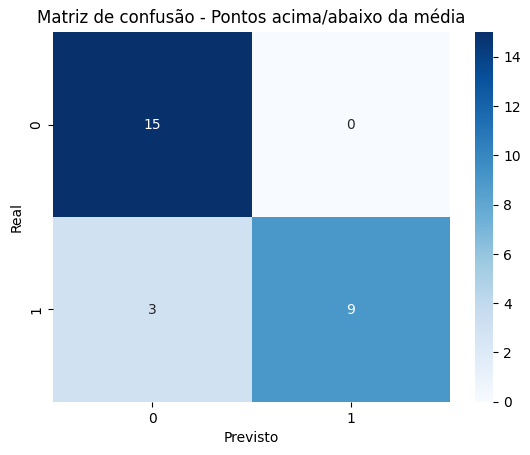

In [44]:
matriz_de_confusao_pontos = confusion_matrix(y_teste_binario['Pontos'], y_pred_binario[:, 0])

sns.heatmap(matriz_de_confusao_pontos, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de confusão - Pontos acima/abaixo da média')
plt.show()

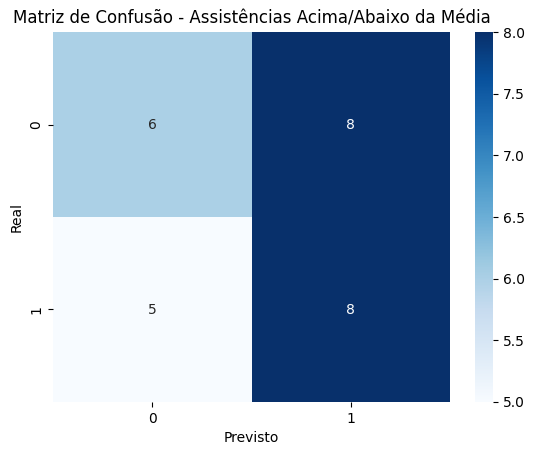

In [45]:
matriz_de_confusao_assistencias = confusion_matrix(y_teste_binario['Assistências'], y_pred_binario[:, 1])
sns.heatmap(matriz_de_confusao_assistencias, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Assistências Acima/Abaixo da Média')
plt.show()

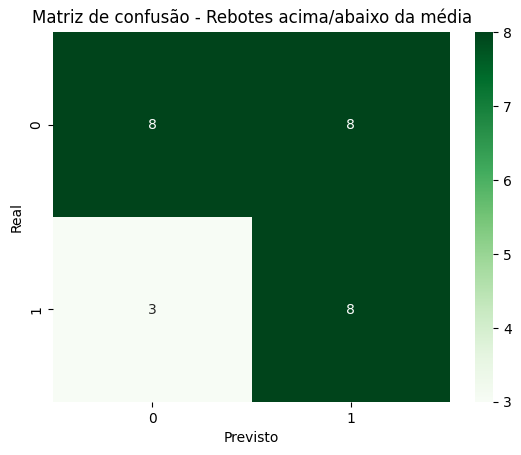

In [46]:
matriz_de_confusao_rebotes = confusion_matrix(y_teste_binario['Rebotes'], y_pred_binario[:, 2])
sns.heatmap(matriz_de_confusao_rebotes, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de confusão - Rebotes acima/abaixo da média')
plt.show()

### Gráficos de probabilidade (histogramas de distribuição - real vs previsto)

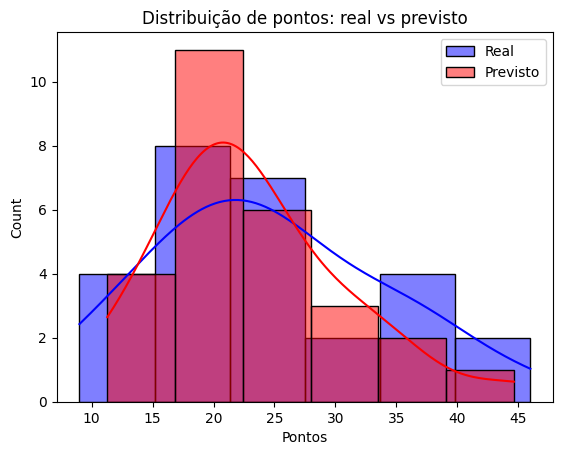

In [32]:
sns.histplot(resultados['Pontos'], color='blue', label='Real', kde=True)
sns.histplot(resultados['Pontos_previstos'], color='red', label='Previsto', kde=True)
plt.legend()
plt.title('Distribuição de pontos: real vs previsto')
plt.show()

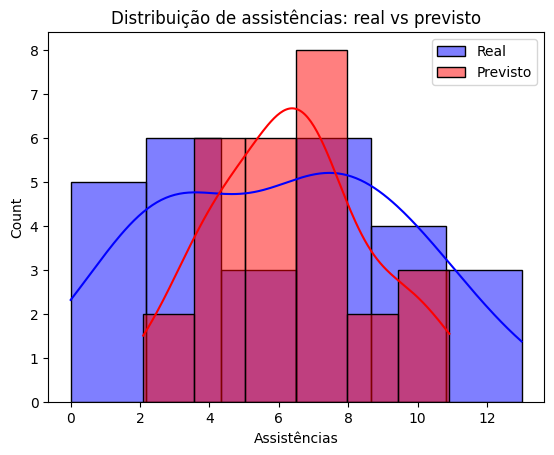

In [47]:
sns.histplot(resultados['Assistências'], color='blue', label='Real', kde=True)
sns.histplot(resultados['Assistências_previstas'], color='red', label='Previsto', kde=True)
plt.legend()
plt.title('Distribuição de assistências: real vs previsto')
plt.show()

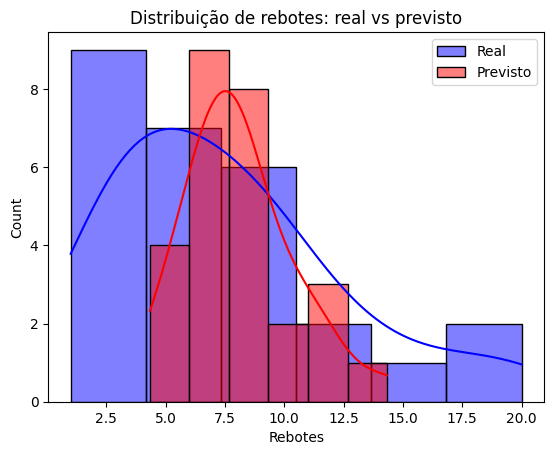

In [48]:
sns.histplot(resultados['Rebotes'], color='blue', label='Real', kde=True)
sns.histplot(resultados['Rebotes_previstos'], color='red', label='Previsto', kde=True)
plt.legend()
plt.title('Distribuição de rebotes: real vs previsto')
plt.show()

### Curva ROC

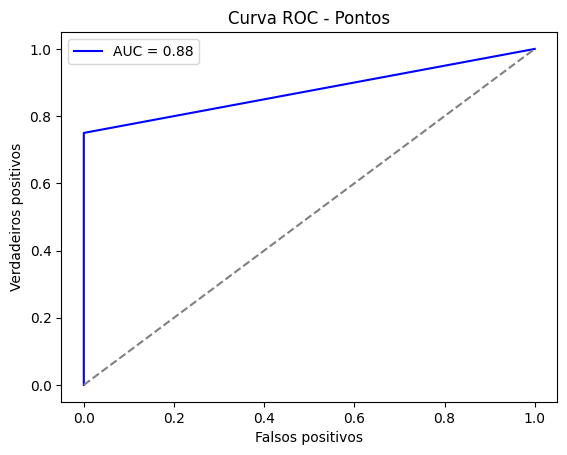

In [49]:
falsos_positivos_pontos, verdadeiros_positivos_pontos, _ = roc_curve(y_teste_binario['Pontos'], y_pred_binario[:, 0])
roc_auc = auc(falsos_positivos_pontos, verdadeiros_positivos_pontos)

plt.plot(falsos_positivos_pontos, verdadeiros_positivos_pontos, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Falsos positivos')
plt.ylabel('Verdadeiros positivos')
plt.title('Curva ROC - Pontos')
plt.legend()
plt.show()

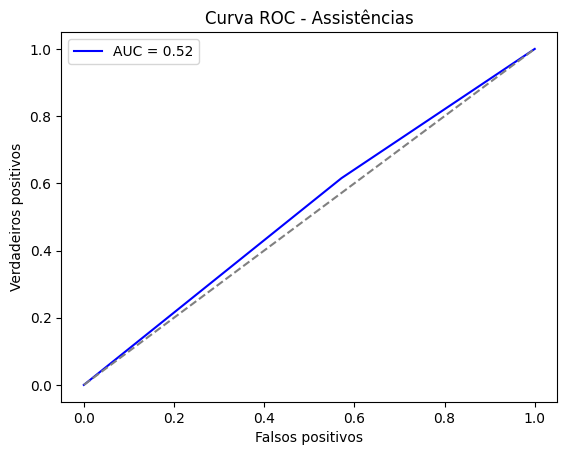

In [50]:
falsos_positivos_assistencias, verdadeiros_positivos_assistencias, _ = roc_curve(y_teste_binario['Assistências'], y_pred_binario[:, 1])
roc_auc_assist = auc(falsos_positivos_assistencias, verdadeiros_positivos_assistencias)

plt.plot(falsos_positivos_assistencias, verdadeiros_positivos_assistencias, color='blue', label=f'AUC = {roc_auc_assist:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Falsos positivos')
plt.ylabel('Verdadeiros positivos')
plt.title('Curva ROC - Assistências')
plt.legend()
plt.show()

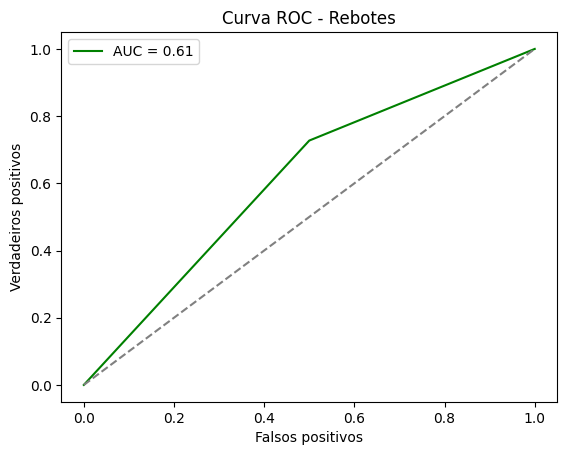

In [51]:
falsos_positivos_rebotes, verdadeiros_positivos_rebotes, _ = roc_curve(y_teste_binario['Rebotes'], y_pred_binario[:, 2])
roc_auc_reb = auc(falsos_positivos_rebotes, verdadeiros_positivos_rebotes)

plt.plot(falsos_positivos_rebotes, verdadeiros_positivos_rebotes, color='green', label=f'AUC = {roc_auc_reb:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Falsos positivos')
plt.ylabel('Verdadeiros positivos')
plt.title('Curva ROC - Rebotes')
plt.legend()
plt.show()

### Gráfico de coeficientes

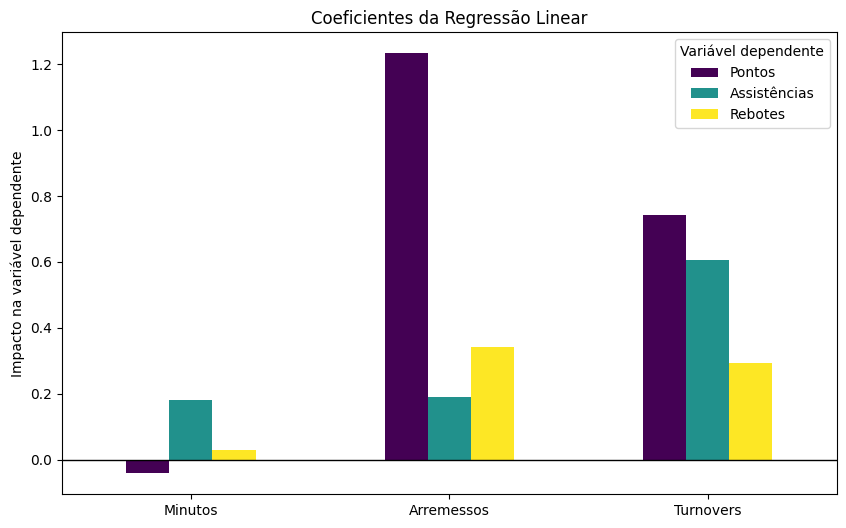

In [37]:
dataframe_coeficientes = pd.DataFrame(modelo.coef_, columns=X.columns, index=['Pontos', 'Assistências', 'Rebotes']).T

dataframe_coeficientes.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.axhline(0, color='black', linewidth=1)
plt.title("Coeficientes da Regressão Linear")
plt.ylabel("Impacto na variável dependente")
plt.xticks(rotation=0)
plt.legend(title="Variável dependente")
plt.show()

### Matriz de correlação

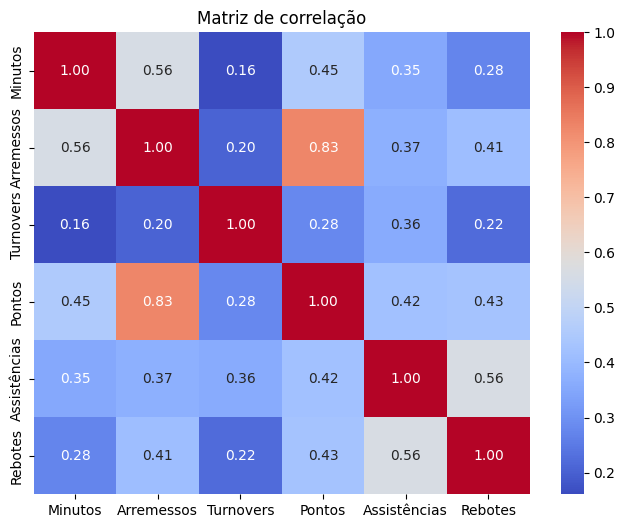

In [41]:
matriz_correlacao = dataframe_nba[['Minutos', 'Arremessos', 'Turnovers', 'Pontos', 'Assistências', 'Rebotes']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlação")
plt.show()
